## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [24]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
import collections
import numpy as np
import random
import pickle
import time

from matplotlib import pyplot as plt

from TCGame_Env import TicTacToe
## defining object for the Tictac toe environment created as MDP in TCGame_env
env = TicTacToe()


In [24]:
pip install gym

     |████████████████████████████████| 1.6MB 714kB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 11.5MB/s eta 0:00:01
  Stored in directory: /Users/mohammedabdulmajid/Library/Caches/pip/wheels/87/e0/91/f56e44e8062f8cd549673da49f59e1d4fe8b17398119b1d221
Successfully built gym
Note: you may need to restart the kernel to use updated packages.


In [25]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [26]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [27]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

In [28]:
# printing the default tic tac toe board positions
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

In [29]:
# Printing all the valid actions
valid_actions(env.state)


[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [30]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    # print(epsilon)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]    #Exploration: randomly choosing and action
    
    return action

In [31]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
# def epsilon_greedy(state, time):
#     epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
#     z = np.random.random()
        
#     if z > epsilon:
#         # get key for max reward using python max dictionary function 
#         s_state = Q_state(state) 
#         action = max(Q_dict[s_state],key=Q_dict[s_state].get)  
#     else:
#         valid_act = valid_actions(state)   
#         action = valid_act[np.random.choice(range(0,len(valid_act)))]    #Exploration: randomly choosing and action
    
#     return action

# assert isinstance(epsilon_greedy(ts1, 1000000),tuple) , "return type is wrong"
# assert len(epsilon_greedy(ts1, 1000000)) == 2, "return len is wrong"

#### Tracking the state-action pairs for checking convergence - write your code here

In [32]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)


In [33]:
# Initialising states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-3-x-x-1-x-x-x-x',(7,5)),('x-5-x-x-x-x-5-7-x',(8,2)),
                       ('x-4-5-3-8-1-6-x-x',(0,7)),('x-4-5-3-8-x-x-x-x',(6,1)),
                       ('x-4-5-2-8-1-6-7-x',(8,3)),('x-x-x-x-x-1-x-x-x',(2,3)),
                       ('x-4-5-3-x-1-6-x-x',(4,7)),('x-4-5-x-8-1-6-x-x',(3,3)),
                       ('x-4-x-3-8-1-6-x-x',(2,5)),('x-4-5-3-8-x-6-x-x',(5,1))]    #select some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []  
  
  

In [34]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [35]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [36]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [37]:
#Defining parameters for the training

EPISODES = 50000
LR = 0.01                   # learning rate
GAMMA = 0.9                # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.001        # epsilon decay rate
threshold = 200       # no of episodes after which states_tracked wwill be saved
policy_threshold = 300   # no of episodes after which Q dictionary/table will be saved


### Q-update loop ---write your code here

In [38]:
import time 
start_time = time.time()

for episode in range(EPISODES):
    env = TicTacToe() # call the environment
    curr_state = env.state    
    done = False  
    add_to_dict(curr_state)  # adding the current state to dictionary

    while done != True:  
        curr_state1 = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)   # applying epislon method
        (next_state, reward, done) = env.step(curr_state, curr_action) # getting rewar
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)


        # Updating rules
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigating to next state
        curr_state = next_state
        
     #states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')
#         print(episode) 

    if ((episode+1)% policy_threshold) == 0:  #every 300th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')  
        

elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

In [39]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.0066349582508622,
              (0, 3): -1.0066319542824582,
              (0, 5): -1.0066338157538939,
              (0, 7): -1.006629233679206,
              (0, 9): -1.0066392043420898,
              (1, 1): -1.0066310868754802,
              (1, 3): -1.006634548471672,
              (1, 5): -1.0066319301091062,
              (1, 7): -1.0066361655791933,
              (1, 9): -1.0066380923981864,
              (2, 1): -1.0066428312652382,
              (2, 3): -1.0066517731158222,
              (2, 5): -1.0066305562542068,
              (2, 7): -1.0066340529750593,
              (2, 9): -1.0066353159454018,
              (3, 1): -1.0066447007728465,
              (3, 3): -1.0066322460189738,
              (3, 5): -1.006644795128585,
              (3, 7): -1.0066287359113664,
              (3, 9): -1.0066423310384371,
              (4, 1): -1.0066455223381074,
              (4, 3): -1.0066336509042337,
              (4, 

#### Check the Q-dictionary

In [40]:
len(Q_dict)

130279

In [41]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [42]:
# Write the code for plotting the graphs for state-action pairs tracked

<function matplotlib.pyplot.show(*args, **kw)>

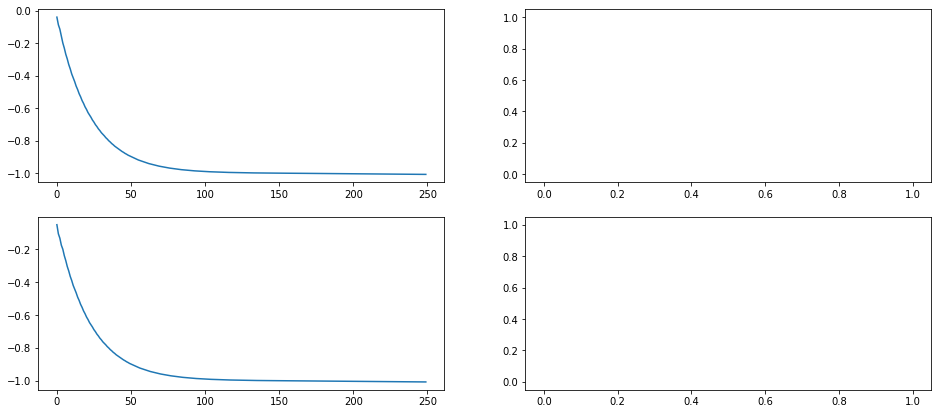

In [43]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-1-x-x-x-x'][(7,5)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-1-x-x-x-x'][(7,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-5-x-x-x-x-5-7-x'][(8,2)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-5-x-x-x-x-5-7-x'][(8,2)]))
plt.show




<function matplotlib.pyplot.show(*args, **kw)>

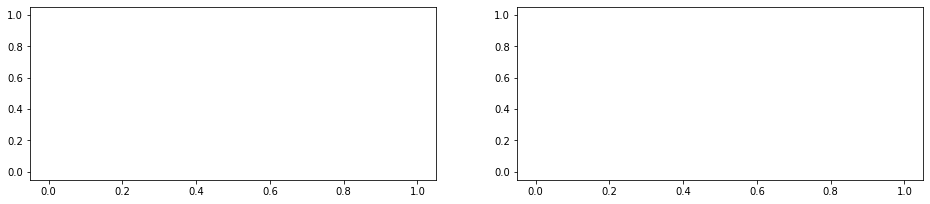

In [54]:
plt.figure(0, figsize=(16,7))
x_axis = np.asarray(range(0, len(States_track['x-4-5-3-8-x-x-x-x'][(6,1)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-4-5-3-8-x-x-x-x'][(6,1)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-4-5-3-x-1-6-x-x'][(4,7)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-4-5-3-x-1-6-x-x'][(4,7)]))
plt.show



### Epsilon - decay check

In [44]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,50000)
epsilon = []
for i in range(0,50000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))
    

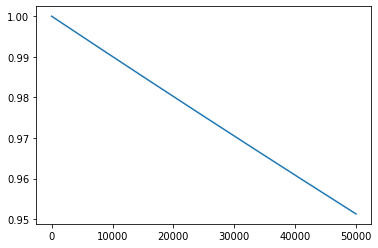

In [45]:
plt.plot(time, epsilon)
plt.show()

### Model 2

In [46]:
#Defining parameters for the training for 5m episodes

EPISODES = 500000
LR = 0.1                   # learning rate
GAMMA = 0.9                # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.001        # epsilon decay rate
threshold = 100       # no of episodes after which states_tracked wwill be saved
policy_threshold = 300   # no of episodes after which Q dictionary/table will be saved

